In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from scipy import signal
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [ ]:
# Must be even number of images
def plot_imgs(img_array, img_labels):
    
    n = len(img_array)
    # Work out the number of rows
    n_rows = int((n / 2) if (n % 2 == 0) else ((n + 1) / 2))

    fig, axs = plt.subplots(nrows=n_rows, ncols=2, figsize=(8,8))

    if n_rows == 1:
        for i in range(n):
            axs[i].set_title(img_labels[i])
            axs[i].imshow(img_array[i], cmap="gray")

    else:
        k=0
        for i in range(n_rows):
            for j in range(2):
                axs[i][j].set_title(img_labels[k])
                axs[i][j].imshow(img_array[k], cmap="gray")
                k += 1

In [ ]:
# Path to images
im_pth = "../../final_project/UCF-EL-Defect/Test_Images/"

#NearSolderPad
nsp_img_list = [
    'M0464C027000.jpg',
    'M0464C016000.jpg',
    'M0464C018000.jpg',
    'M0465C014000.jpg',
]

non_defective = [
    'M0377C017010.jpg',
    'Bent Cure 0Pa TestName_20201222_165250.586_C034.jpg'
]

# Load files
img_array_ok = [plt.imread(f'{im_pth}'+i) for i in non_defective]
img_array_defected = [plt.imread(f'{im_pth}'+i) for i in nsp_img_list]

#Plot OK
plot_imgs(img_array_ok, non_defective)

In [ ]:
#Plot Near Solder Pad
plot_imgs(img_array_defected, nsp_img_list)

### Simple Edge Detection:

In [ ]:
kernel= np.array([[-1,  0,  1], 
                  [-4,  0,  4],
                  [-1,  0,  1]])

filtered = []
for img in img_array_ok:
    img_bw = cv2.cvtColor(src=img, code=cv2.COLOR_BGR2GRAY)
    new_img = signal.convolve(img_bw, kernel)
    filtered.append(new_img)

plot_imgs(filtered, non_defective)

In [ ]:
kernel= np.array([[-1,  0,  1], 
                  [-4,  0,  4],
                  [-1,  0,  1]])

filtered = []
for img in img_array_defected:
    img_bw = cv2.cvtColor(src=img, code=cv2.COLOR_BGR2GRAY)
    new_img = signal.convolve(img_bw, kernel)
    filtered.append(new_img)

plot_imgs(filtered, nsp_img_list)

This is good for finding Front Grid Interruptions but not Near Solder Pad

### Harris Corners:

In [ ]:
# compute the key points from input grayscale images
def HarrisKeypointDetector(in_image, n, w, k, verbose=False):
    
    # STEP 1:
    # compute the points where there are good corners in the image
    # the score for good corners are computed as follows:
    # harrisImage = det(H) - k(trace(H))^2
    # where H = A.T*A seen in the async lecture
    
    # parameters to cv2.cornerHarris are:
    #   grayscale image
    #   n = size of the window to compute the A
    #   w = size of the kernel to compute the gradients
    #   k = value for k in det(H) - k(trace(H))^2
    in_image = cv2.cvtColor(in_image, cv2.COLOR_BGR2GRAY)
    harrisImage = cv2.cornerHarris(in_image, n, w, k)
    
    # STEP 2:
    # threshold the scores to keep only interesting features
    thresh = 0.1 * harrisImage.max()
    harrisMaxImage = harrisImage > thresh
    
    # STEP 3:
    # get keypoints structure from the detected features
    height, width = in_image.shape[:2]
    features = []
    for y in range(height):
        for x in range(width):
            
            # do not include if it is not in the good features
            if not harrisMaxImage[y, x]:
                continue

            # fill in the parameters
            f = cv2.KeyPoint()
            f.pt = (x, y)
            f.response = harrisImage[y,x]
            features.append(f)

    if verbose:
      fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,7))
      ax[0].imshow(drawKeyPts(in_image, features)); ax[0].axis('off')
      ax[0].set_title('image')
      har_im = ax[1].imshow(harrisImage, cmap='gray'); ax[1].axis('off')
      # create an axes on the right side of ax. The width of cax will be 5%
      # of ax and the padding between cax and ax will be fixed at 0.05 inch.
      divider = make_axes_locatable(ax[1])
      cax = divider.append_axes("right", size="5%", pad=0.05)
      plt.colorbar(har_im, cax=cax)
      ax[1].set_title('score')
      plt.suptitle('KEYPOINTS')
      plt.show()
            
    return features

# input a grayscale image and draw keypoints
def drawKeyPts(grayImage, keyp):
    
    out_im = (grayImage * 255).astype(np.uint8)
    out_im = np.concatenate((out_im[:, :, np.newaxis], 
                             out_im[:, :, np.newaxis], 
                             out_im[:, :, np.newaxis]), axis=2)
    
    for curKey in keyp:
        x=np.int32(curKey.pt[0])
        y=np.int32(curKey.pt[1])
        size = np.int32(curKey.size)
        cv2.circle(out_im, (x,y), 8, [255, 0, 0], 
                   thickness=2, lineType=8, shift=0)

    return out_im

In [ ]:
for img in img_array_ok:
    features = HarrisKeypointDetector(img, n=8, w=5, k=0.2, verbose=True)


In [ ]:
for img in img_array_defected:
    features = HarrisKeypointDetector(img, n=8, w=5, k=0.2, verbose=True)

This did not find "corners" of the Near Solder Pad defects.

### Total Edge Detection with Canny Filter

In [ ]:
magnitude_imgs = []
canny_imgs = []
for img in img_array_ok:
    im_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(im_gray, cv2.CV_32F, 1, 0, ksize=21) # Find x and y gradients
    sobely = cv2.Sobel(im_gray, cv2.CV_32F, 0, 1, ksize=21)
    magnitude = np.sqrt(sobelx**2.0 + sobely**2.0)
    magnitude = magnitude / np.max(magnitude) # normalize
    magnitude_imgs.append(magnitude)
    im_threshold = cv2.Canny(image=(magnitude * 255).astype(np.uint8), threshold1=0, threshold2=200) # Canny Edge 
    im_threshold = im_threshold / np.max(im_threshold) # normalize
    canny_imgs.append(im_threshold)


plot_imgs(magnitude_imgs, non_defective)
plot_imgs(canny_imgs, non_defective)

In [ ]:
magnitude_imgs = []
canny_imgs = []
for img in img_array_defected:
    im_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(im_gray, cv2.CV_32F, 1, 0, ksize=21) # Find x and y gradients
    sobely = cv2.Sobel(im_gray, cv2.CV_32F, 0, 1, ksize=21)
    magnitude = np.sqrt(sobelx**2.0 + sobely**2.0)
    magnitude = magnitude / np.max(magnitude) # normalize
    magnitude_imgs.append(magnitude)
    im_threshold = cv2.Canny(image=(magnitude * 255).astype(np.uint8), threshold1=0, threshold2=200) # Canny Edge 
    im_threshold = im_threshold / np.max(im_threshold) # normalize
    canny_imgs.append(im_threshold)

plot_imgs(magnitude_imgs, nsp_img_list)
plot_imgs(canny_imgs, nsp_img_list)

This might be useful once we filter out busbars and 

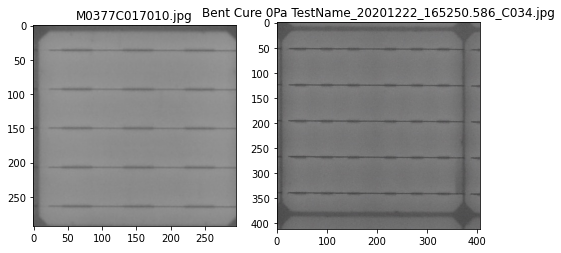

In [19]:
# Path to images
im_pth = "../../final_project/UCF-EL-Defect/Test_Images/"

#NearSolderPad
nsp_img_list = [
    'M0464C027000.jpg',
    'M0464C016000.jpg',
    'M0464C018000.jpg',
    'M0465C014000.jpg',
]

non_defective = [
    'M0377C017010.jpg',
    'Bent Cure 0Pa TestName_20201222_165250.586_C034.jpg'
]

# Load files
img_array_ok = [plt.imread(f'{im_pth}'+i) for i in non_defective]
img_array_defected = [plt.imread(f'{im_pth}'+i) for i in nsp_img_list]

#Plot OK
plot_imgs(img_array_ok, non_defective)

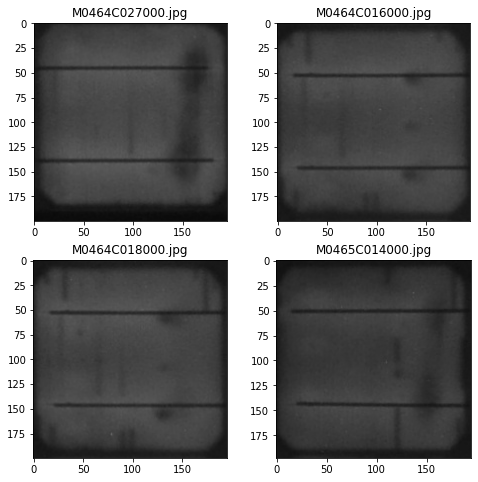

In [20]:
#Plot Near Solder Pad
plot_imgs(img_array_defected, nsp_img_list)

### Simple Edge Detection:

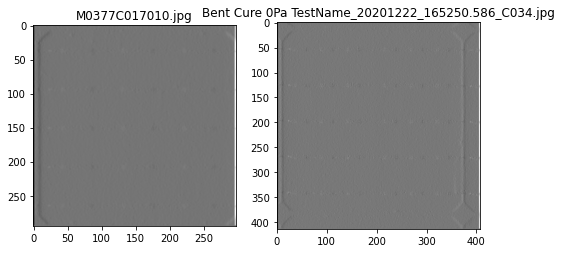

In [34]:
kernel= np.array([[-1,  0,  1], 
                  [-4,  0,  4],
                  [-1,  0,  1]])

filtered = []
for img in img_array_ok:
    img_bw = cv2.cvtColor(src=img, code=cv2.COLOR_BGR2GRAY)
    new_img = signal.convolve(img_bw, kernel)
    filtered.append(new_img)

plot_imgs(filtered, non_defective)

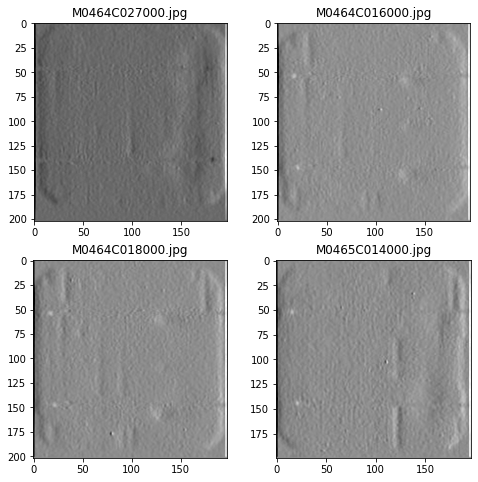

In [35]:
kernel= np.array([[-1,  0,  1], 
                  [-4,  0,  4],
                  [-1,  0,  1]])

filtered = []
for img in img_array_defected:
    img_bw = cv2.cvtColor(src=img, code=cv2.COLOR_BGR2GRAY)
    new_img = signal.convolve(img_bw, kernel)
    filtered.append(new_img)

plot_imgs(filtered, nsp_img_list)

This is good for finding Front Grid Interruptions but not Near Solder Pad

### Harris Corners:

In [41]:
# compute the key points from input grayscale images
def HarrisKeypointDetector(in_image, n, w, k, verbose=False):
    
    # STEP 1:
    # compute the points where there are good corners in the image
    # the score for good corners are computed as follows:
    # harrisImage = det(H) - k(trace(H))^2
    # where H = A.T*A seen in the async lecture
    
    # parameters to cv2.cornerHarris are:
    #   grayscale image
    #   n = size of the window to compute the A
    #   w = size of the kernel to compute the gradients
    #   k = value for k in det(H) - k(trace(H))^2
    in_image = cv2.cvtColor(in_image, cv2.COLOR_BGR2GRAY)
    harrisImage = cv2.cornerHarris(in_image, n, w, k)
    
    # STEP 2:
    # threshold the scores to keep only interesting features
    thresh = 0.1 * harrisImage.max()
    harrisMaxImage = harrisImage > thresh
    
    # STEP 3:
    # get keypoints structure from the detected features
    height, width = in_image.shape[:2]
    features = []
    for y in range(height):
        for x in range(width):
            
            # do not include if it is not in the good features
            if not harrisMaxImage[y, x]:
                continue

            # fill in the parameters
            f = cv2.KeyPoint()
            f.pt = (x, y)
            f.response = harrisImage[y,x]
            features.append(f)

    if verbose:
      fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,7))
      ax[0].imshow(drawKeyPts(in_image, features)); ax[0].axis('off')
      ax[0].set_title('image')
      har_im = ax[1].imshow(harrisImage, cmap='gray'); ax[1].axis('off')
      # create an axes on the right side of ax. The width of cax will be 5%
      # of ax and the padding between cax and ax will be fixed at 0.05 inch.
      divider = make_axes_locatable(ax[1])
      cax = divider.append_axes("right", size="5%", pad=0.05)
      plt.colorbar(har_im, cax=cax)
      ax[1].set_title('score')
      plt.suptitle('KEYPOINTS')
      plt.show()
            
    return features

# input a grayscale image and draw keypoints
def drawKeyPts(grayImage, keyp):
    
    out_im = (grayImage * 255).astype(np.uint8)
    out_im = np.concatenate((out_im[:, :, np.newaxis], 
                             out_im[:, :, np.newaxis], 
                             out_im[:, :, np.newaxis]), axis=2)
    
    for curKey in keyp:
        x=np.int32(curKey.pt[0])
        y=np.int32(curKey.pt[1])
        size = np.int32(curKey.size)
        cv2.circle(out_im, (x,y), 8, [255, 0, 0], 
                   thickness=2, lineType=8, shift=0)

    return out_im

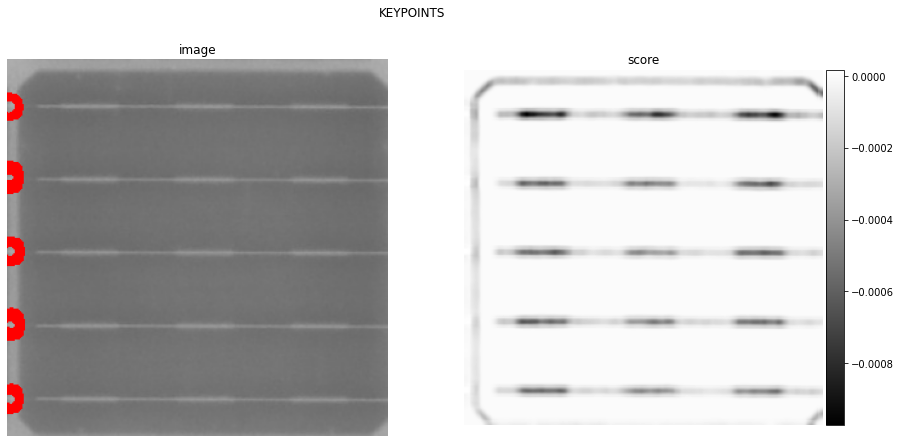

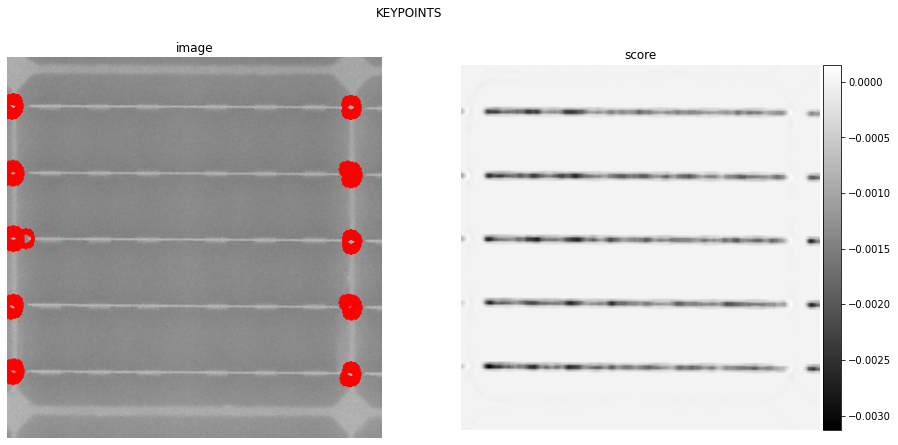

In [55]:
for img in img_array_ok:
    features = HarrisKeypointDetector(img, n=8, w=5, k=0.2, verbose=True)


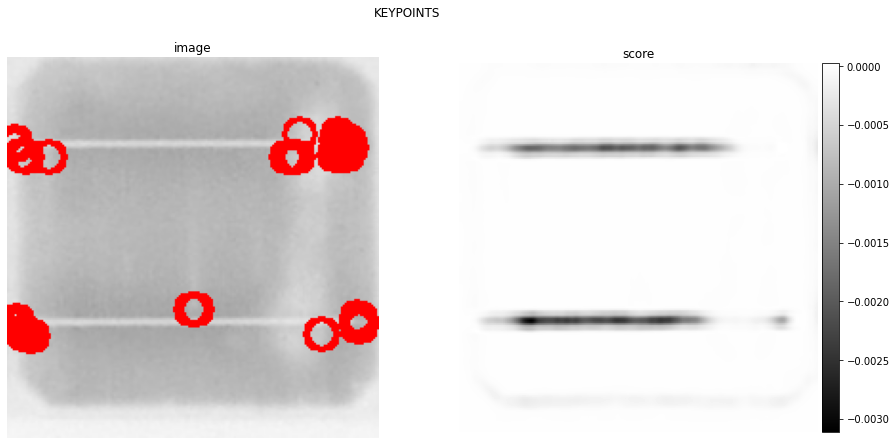

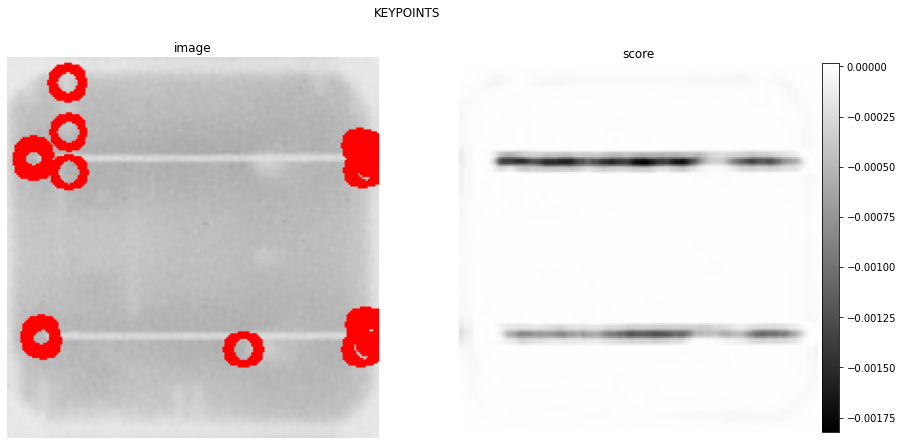

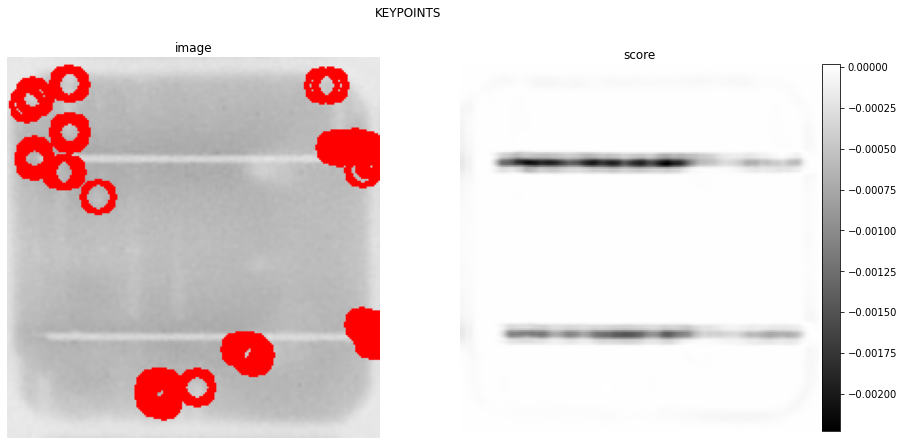

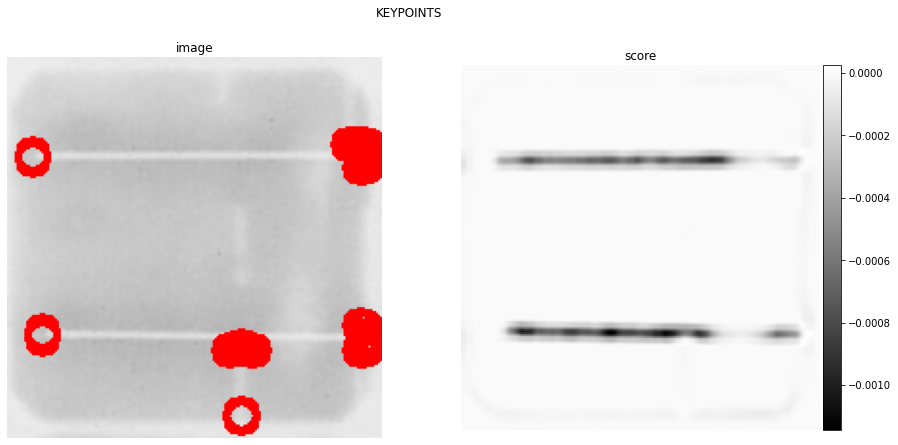

In [56]:
for img in img_array_defected:
    features = HarrisKeypointDetector(img, n=8, w=5, k=0.2, verbose=True)

This did not find "corners" of the Near Solder Pad defects.

### Total Edge Detection with Canny Filter

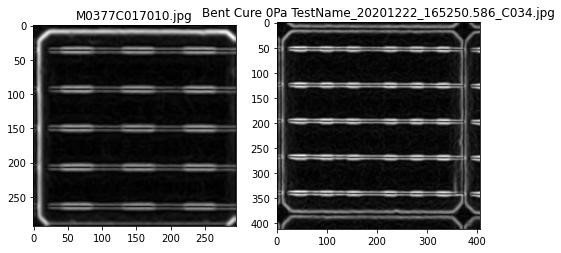

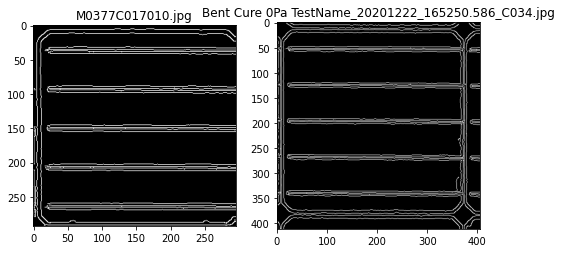

In [73]:
magnitude_imgs = []
canny_imgs = []
for img in img_array_ok:
    im_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(im_gray, cv2.CV_32F, 1, 0, ksize=21) # Find x and y gradients
    sobely = cv2.Sobel(im_gray, cv2.CV_32F, 0, 1, ksize=21)
    magnitude = np.sqrt(sobelx**2.0 + sobely**2.0)
    magnitude = magnitude / np.max(magnitude) # normalize
    magnitude_imgs.append(magnitude)
    im_threshold = cv2.Canny(image=(magnitude * 255).astype(np.uint8), threshold1=0, threshold2=200) # Canny Edge 
    im_threshold = im_threshold / np.max(im_threshold) # normalize
    canny_imgs.append(im_threshold)


plot_imgs(magnitude_imgs, non_defective)
plot_imgs(canny_imgs, non_defective)

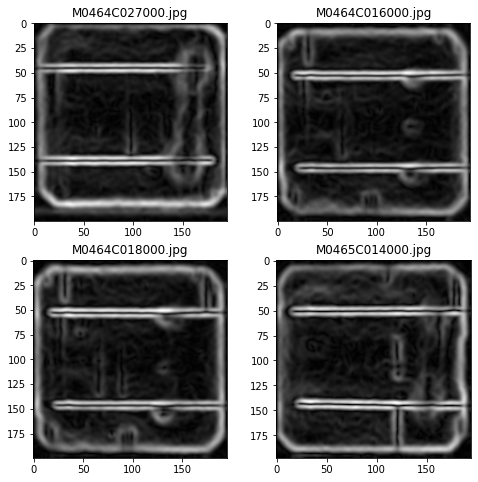

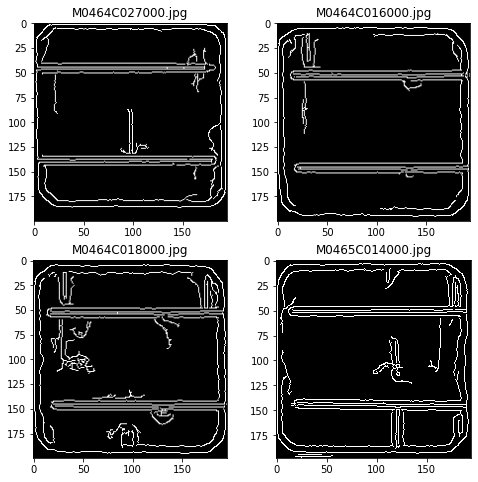

In [71]:
magnitude_imgs = []
canny_imgs = []
for img in img_array_defected:
    im_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(im_gray, cv2.CV_32F, 1, 0, ksize=21) # Find x and y gradients
    sobely = cv2.Sobel(im_gray, cv2.CV_32F, 0, 1, ksize=21)
    magnitude = np.sqrt(sobelx**2.0 + sobely**2.0)
    magnitude = magnitude / np.max(magnitude) # normalize
    magnitude_imgs.append(magnitude)
    im_threshold = cv2.Canny(image=(magnitude * 255).astype(np.uint8), threshold1=0, threshold2=200) # Canny Edge 
    im_threshold = im_threshold / np.max(im_threshold) # normalize
    canny_imgs.append(im_threshold)

plot_imgs(magnitude_imgs, nsp_img_list)
plot_imgs(canny_imgs, nsp_img_list)

This might be useful once we filter out busbars and 